# Acquire the data
- This notebook is supposed to be run using Google Colab
- The notebook will be accessing the datasets from Google Drive
- To get started:
  - Download the data from https://zindi.africa/hackathons/to-vaccinate-or-not-to-vaccinate-its-not-a-question/data
  - Create a folder in which you would like to add your data e.g: `vaccinate`
  - Upload the data to a sub-folder called `data` Acquisatione.g: `vaccinate/data`
  - Create two sub-folders called `models` and `submissions` e.g: `vaccinate/models` and `vaccinate/submissions`
- Now, you are ready to run the notebook

# Mount Google Drive

In [1]:
# Mount Google Drive to be able to access files stored there
from google.colab import drive
drive.mount('/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive/


In [2]:
# Navigate to the folder containing the data and empty models folder
% cd "/drive/My Drive/vaccinate"

/drive/My Drive/vaccinate


# Load the datasets

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [0]:
train_df, dev_df = train_test_split(pd.read_csv('data/Train.csv').dropna(), random_state=42)

In [0]:
test_df = pd.read_csv('data/Test.csv')

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7499 entries, 4902 to 7272
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   7499 non-null   object 
 1   safe_text  7499 non-null   object 
 2   label      7499 non-null   float64
 3   agreement  7499 non-null   float64
dtypes: float64(2), object(2)
memory usage: 292.9+ KB


# Install transformers package
Huggingface's `transformers` package provides an easy way to fine-tune pretrained models such as `BERT`

In [7]:
! pip install transformers

     |████████████████████████████████| 573kB 8.9MB/s 
     |████████████████████████████████| 3.7MB 24.8MB/s 
     |████████████████████████████████| 1.0MB 53.0MB/s 
     |████████████████████████████████| 890kB 55.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=011d2fe9975cad61603c9d0006f42a5480f31939c1a603542a6100f44123b2ac
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


# Investigate the no of tokens in each tweet
`BERT` is a deep neural networks. To train these networks, one need to divide the dataset into batches. Samples in each batch should have the same number of tokens such that the data can be represented as a matrix. This is a cruical point to make sure that the model is trained on each minibatch.

In [8]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-large-cased')

In [0]:
tokens = train_df['safe_text'].apply(lambda s: tokenizer.encode(s))

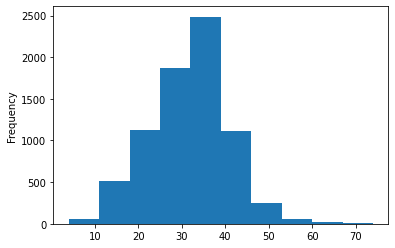

In [10]:
pd.Series([len(l) for l in tokens]).plot.hist()

# Define the used model
- The model will use data that is truncated (or padded) to 50 tokens since most of the tweets have less than 50 tokens.

In [0]:
# Setting the seed this way doesn't make my results reproducible!
import random
import numpy as np
import torch
seed = 42
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(seed)

In [0]:
import numpy as np
from scipy.special import softmax
from torch import nn, optim, tensor, argmax
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

class CustomDataset(Dataset):
    '''
    This class provides a way to tokenize the dataset such that it is used
    by pytorch's dataloader
    '''
    def __init__(self, dataframe, model_name, max_seq_length=50, pad_to_max_length=True, is_test=False):
        self.len = len(dataframe)
        self.data = dataframe
        self.max_seq_length = max_seq_length
        self.pad_to_max_length = pad_to_max_length
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.is_test = is_test

    def encode(self, sentence):
        # This adds [CLS] and [SEP] by default
        return self.tokenizer.encode(
            sentence, max_length=self.max_seq_length, pad_to_max_length=self.pad_to_max_length)

    def __getitem__(self, index):
        # This function is used by the dataloader
        item = self.data.iloc[index]
        text = item['safe_text']
        if self.is_test:
          label = -1
        else:
          # Pytorch doesn't support using -1 as a label
          # Thus, labels are mapped to [0, 1, 2] instead of [-1, 0, 1]
          label = 1 + int(item['label'])
        X = self.encode(text)
        return tensor(X), label

    def __len__(self):
        # This function is used by the dataloader
        return self.len

class BertModel:
    def __init__(self, model_name, config):
        self.model_name = model_name
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).cuda()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def get_params(self):
        return self.model.parameters()

    def fit(self, train_df, epochs=4, learning_rate=1e-05, weight_decay=1e-5, params=None):
        if not params:
            params = {'batch_size': 30,
                     'shuffle': False,
                     'drop_last': False,
                     'num_workers': 1}

        train_dataloader = DataLoader(
            CustomDataset(train_df, self.model_name, max_seq_length=50, pad_to_max_length=True),
            **params)

        # Create optimizer
        # nn.MSELoss() was also used but didn't improve the results
        loss_function = nn.CrossEntropyLoss()

        optimizer = optim.Adam(params = self.get_params(), lr=learning_rate, weight_decay=weight_decay)

        self.model.train()
        average_loss = 0

        for epoch in range(epochs):
            for batch_number, (tokens, labels) in enumerate(train_dataloader):
                tokens = tokens.cuda()
                labels = labels.cuda()

                optimizer.zero_grad()
                # Forward pass
                outputs = self.model.forward(tokens)[0]
                predicted = argmax(outputs, dim=1)
                loss = loss_function(outputs, labels)
                # Backward pass
                loss.backward()
                optimizer.step()
                average_loss += loss
                if batch_number % 100 == 0:
                    average_loss = average_loss / 100
                    print(f'Epoch {epoch}: Batch {batch_number} -> Average loss {average_loss}')
                    average_loss = 0

    def predict(self, df, params=None):
        '''This function only chooses the most probable class'''
        if not params:
            params = {'batch_size': 100,
                     'shuffle': False,
                     'drop_last': False,
                     'num_workers': 1}
        dataloader = DataLoader(
            CustomDataset(df, self.model_name, max_seq_length=50, pad_to_max_length=True, is_test=True),
            **params)
        predictions = []
        self.model.eval()
        with torch.no_grad():
          for batch_number, (tokens, labels) in enumerate(dataloader):
              tokens = tokens.cuda()

              outputs = self.model.forward(tokens)[0]
              predicted = argmax(outputs, dim=1)
              predictions = predictions + predicted.tolist()
        # Pytorch doesn't support using -1 as a label
        # Thus, labels are mapped to [0, 1, 2] instead of [-1, 0, 1] on training the model
        # They are remapped again to [-1, 0, 1] by subtracting one
        return [p-1 for p in predictions]

    def predict_prob(self, df, params=None):
        '''This function only chooses the expected value for the prediction class.
        If the probabilities of labels [-1, 0, 1] were [P-1, P0, P1],
        then the predicted class is (-1 * P-1) + 0 * P0 + (1 *P1).
        This is used since the evaluation criteria was Least Square Error and not F1 score.
        '''
        if not params:
            params = {'batch_size': 100,
                     'shuffle': False,
                     'drop_last': False,
                     'num_workers': 1}
        dataloader = DataLoader(
            CustomDataset(df, self.model_name, max_seq_length=50, pad_to_max_length=True, is_test=True),
            **params)
        predictions = []
        self.model.eval()
        label_scores = np.array([[-1,0,1]]).T
        with torch.no_grad():
          for batch_number, (tokens, labels) in enumerate(dataloader):
              tokens = tokens.cuda()

              outputs = self.model.forward(tokens)[0]
              probabilities = softmax(outputs.cpu().detach().numpy(), axis=1)

              # Find the most expected value
              scores = np.matmul(probabilities, label_scores).T.tolist()
              predictions = predictions + scores
        return predictions

    def save_model(self, directory):
        # Model save
        torch.save(self.model.state_dict(), str(Path(directory, self.model_name)))


# Train the model

In [0]:
# This step is required to inform BERT that the model will be used in a three class classification problem
labels = [-1, 0, 1]
label_map = {i:i for i in labels}
num_labels = len(labels)
config = AutoConfig.from_pretrained('bert-large-cased',
                           num_labels=num_labels,
                           id2label=label_map,
                           label2id={label: i for i, label in enumerate(labels)})

In [14]:
model = BertModel('bert-large-cased', config)

In [15]:
model.fit(train_df, epochs=4)

Epoch 0: Batch 0 -> Average loss 0.00861161295324564
Epoch 0: Batch 100 -> Average loss 0.8509868383407593
Epoch 0: Batch 200 -> Average loss 0.7442072629928589
Epoch 1: Batch 0 -> Average loss 0.3312857449054718
Epoch 1: Batch 100 -> Average loss 0.6494563221931458
Epoch 1: Batch 200 -> Average loss 0.628110945224762
Epoch 2: Batch 0 -> Average loss 0.27562034130096436
Epoch 2: Batch 100 -> Average loss 0.5344231128692627
Epoch 2: Batch 200 -> Average loss 0.5034850239753723
Epoch 3: Batch 0 -> Average loss 0.20945148169994354
Epoch 3: Batch 100 -> Average loss 0.39582008123397827
Epoch 3: Batch 200 -> Average loss 0.37000197172164917


# Evaluate the model

In [0]:
def get_score(pr,la):
    '''
    This function is used to compute the accuracy and the Least Square Error
    Inputs:
      pr: List of predicted values
      la: List of labels [-1, 0, 1]
    '''
    return sum([p==l for p, l in zip(pr, la)])/len(pr), (sum([(p-l) ** 2 for p, l in zip(pr, la)])/len(pr)) ** 0.5

In [17]:
get_score(model.predict(train_df), train_df['label'])

(0.9250566742232298, 0.35853936101417494)

In [18]:
get_score(sum(model.predict_prob(train_df), []), train_df['label'])

(0.0, 0.32422849175833257)

In [19]:
get_score(model.predict(dev_df), dev_df['label'])

(0.7628, 0.6125357132445421)

In [20]:
get_score(sum(model.predict_prob(dev_df), []), dev_df['label'])

(0.0, 0.5391030964548473)

# Create the submission csv file

In [0]:
# This step is used to handle a bug in the test dataset
sample_submission = pd.read_csv('data/SampleSubmission.csv')
submission_df = sample_submission.merge(test_df, how='left', on='tweet_id')
submission_df['safe_text'].fillna('', inplace=True)

In [0]:
submission_pred = sum(model.predict_prob(submission_df), [])

In [23]:
len(submission_pred), submission_df.shape

(5177, (5177, 3))

In [0]:
submission_df['target'] = submission_pred

In [0]:
submission_df[['tweet_id', 'target']].to_csv('submissions/submission.csv', index=False)

# Save the model weights
I generally tend to save the model's weights since I sometimes struggle with reproducing the results.

It's also useful in case of blending the predictions of multiple models (Avoid re-training the models).

In [0]:
from pathlib import Path
torch.save(model.model.state_dict(), str(Path('models', model.model_name + '-0')))